# problem2 
## Convolutional Neural Network for Recognition

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import cv2

In [10]:
# read data(TSRD)
train_data = pd.read_csv("train.csv") 
test_data = pd.read_csv("test.csv")

In [11]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(8 * 8 * 64 , 64)
        self.fc2 = nn.Linear(64, 2)
        self.fc3 = nn.Linear(2, 7)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(-1, 8 * 8 * 64)
        x = self.fc1(x)
        x = F.relu(x)
        self.output = self.fc2(x)
        x = self.fc3(self.output)
        
        return x

In [12]:
# plot learning curves and accuracy rate
def plot(train_loss, train_acc, test_loss, test_acc):
    plt.title("learning curves")
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
    plt.title("accuracy rate")
    plt.plot(train_acc, label='train accuracy')
    plt.plot(test_acc, label='test accuracy')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

## 1. CNN for image recognition by using Traffic Sign Recognition Dataset

In [13]:
# data without cropping
def data_init(data):
    data_list =[]
    transform1 = transforms.Compose([
        transforms.ToTensor(),
        ])
    
    for i in range(len(data)):
        name = data.iloc[i].file_name
        img = cv2.imread('images/' + name)
        c_img = cv2.resize(img,dsize = (32, 32), interpolation = cv2.INTER_AREA)
        plt.imshow(c_img)
        tensor = transform1(c_img)
        data_list.append(tensor)
    #print(data_list)
    return data_list

### (a) Plot the learning curve and the accuracy rate of training and test data.

image without cropping


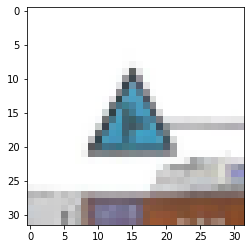

In [14]:
batch_size = 16
print('image without cropping')
x_train = torch.stack(data_init(train_data))
x_test =  torch.stack(data_init(test_data))
y_train = torch.from_numpy(np.asarray(train_data['category']))
y_test = torch.from_numpy(np.asarray(test_data['category'])) 

train = TensorDataset(x_train, y_train)
train_loader = DataLoader(train, batch_size)
test = TensorDataset(x_test, y_test)
test_loader = DataLoader(test, len(test_data))

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=7, bias=True)
)


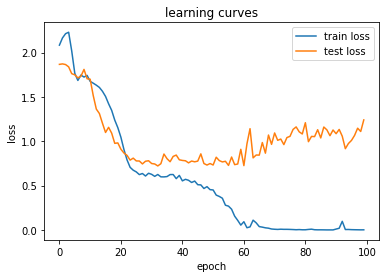

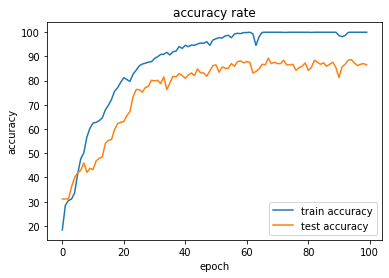

In [15]:
net = CNN()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

train_loss = []
train_acc = []
test_loss = []
test_acc = []
scatter_epoch = []
for epoch in range(100):
    train_correct = 0
    train_total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, train_labels = data
        optimizer.zero_grad()
        outputs = net(inputs) # (n_samples, channels, height, width)
        # train loss
        loss = criterion(outputs, train_labels)
        
        # accuracy
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()
        # backward
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())  
    train_acc.append(100 * train_correct/ train_total)
    #print('Train Accuracy:',100 * train_correct/ train_total)
    
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_loader:
            images, test_labels = data
            outputs = net(images)
            # test loss
            loss = criterion(outputs, test_labels)
            # accuracy
            _, test_predicted = torch.max(outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
    if epoch == 5:
        scatter_epoch.append([net.output, y_test, epoch])
    elif epoch == 20:
        scatter_epoch.append([net.output, y_test, epoch])
    elif epoch == 70:
        scatter_epoch.append([net.output, y_test, epoch])
    test_loss.append(loss.item())
    test_acc.append(100 * test_correct/ test_total)
    #print('Test Accuracy:',100 * test_correct/ test_total)

plot(train_loss, train_acc, test_loss, test_acc) 

### (b) Plot the latent feature distributions of test data at dierent training stages.

In [16]:
def scatter_plot(data, y_test):
    data = pd.DataFrame(data.numpy(), columns = ['x', 'y'])
    y_test = pd.DataFrame(y_test.numpy())
    data['label'] = y_test
    data.sort_values(by = ['label'], inplace = True)
    #print(data)
    colors = {0:'r', 1:'b', 2:'g', 3:'c', 4:'m', 5:'y', 6:'k'}
    
    fig, ax = plt.subplots()
    grouped = data.groupby('label')
    for key, group in grouped:
        group.plot(ax = ax, kind = 'scatter', x = 'x', y = 'y', label = key, color = colors[key])
    plt.show()

5th learning epochs


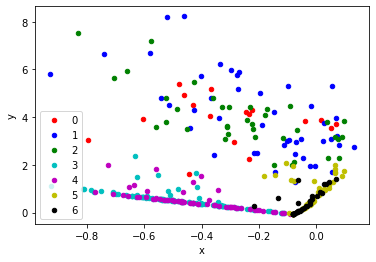

20th learning epochs


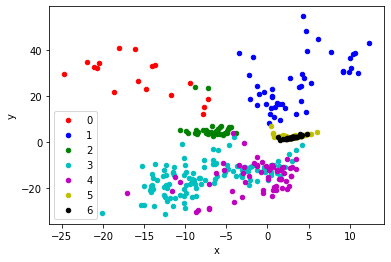

70th learning epochs


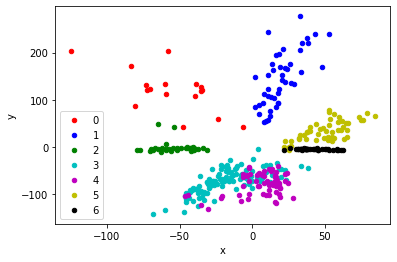

In [17]:
for i in scatter_epoch:
    print('%dth learning epochs'%i[2])
    scatter_plot(i[0], i[1])

從5 epoch到70 epoch可以看出同一類別漸漸聚集成同一群，但仍然有少數重疊的部分。

## 2. images with cropping

In [18]:
# data without cropping
def crop_data(data):
    data_list =[]
    transform1 = transforms.Compose([
        transforms.ToTensor(),
        ])
    
    for i in range(len(data)):
        name = data.iloc[i].file_name
        img = cv2.imread('images/' + name)
        img = img[data.iloc[i].y1: data.iloc[i].y2, data.iloc[i].x1: data.iloc[i].x2]
        c_img = cv2.resize(img,dsize = (32, 32), interpolation = cv2.INTER_AREA)
        plt.imshow(c_img)
        tensor = transform1(c_img)
        data_list.append(tensor)
    return data_list

### (a) Plot the learning curve, accuracy rate and the latent feature distributions of test data.

image with cropping


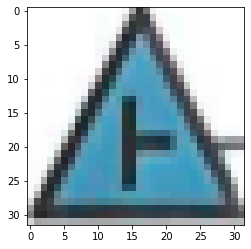

In [19]:
batch_size = 16
print('image with cropping')
x_train = torch.stack(crop_data(train_data))
x_test =  torch.stack(crop_data(test_data))
y_train = torch.from_numpy(np.asarray(train_data['category']))
y_test = torch.from_numpy(np.asarray(test_data['category'])) 

train = TensorDataset(x_train, y_train)
train_loader = DataLoader(train, batch_size)
test = TensorDataset(x_test, y_test)
test_loader = DataLoader(test, len(test_data))

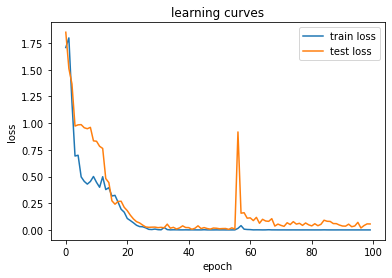

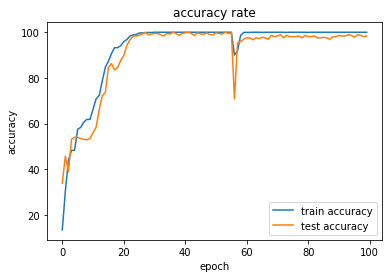

In [20]:
net = CNN()
#print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

train_loss = []
train_acc = []
test_loss = []
test_acc = []
scatter_epoch = []
for epoch in range(100):
    train_correct = 0
    train_total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, train_labels = data
        optimizer.zero_grad()
        outputs = net(inputs) # (n_samples, channels, height, width)
        # train loss
        loss = criterion(outputs, train_labels)
        
        # accuracy
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()
        # backward
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())  
    train_acc.append(100 * train_correct/ train_total)
    #print('Train Accuracy:',100 * train_correct/ train_total)
    
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_loader:
            images, test_labels = data
            outputs = net(images)
            # test loss
            loss = criterion(outputs, test_labels)
            # accuracy
            _, test_predicted = torch.max(outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
    if epoch == 5:
        scatter_epoch.append([net.output, y_test, epoch])
    elif epoch == 20:
        scatter_epoch.append([net.output, y_test, epoch])
    elif epoch == 70:
        scatter_epoch.append([net.output, y_test, epoch])
    test_loss.append(loss.item())
    test_acc.append(100 * test_correct/ test_total)
    #print('Test Accuracy:',100 * test_correct/ test_total)

plot(train_loss, train_acc, test_loss, test_acc) 

### latent feature distributions of test data.

5th learning epochs


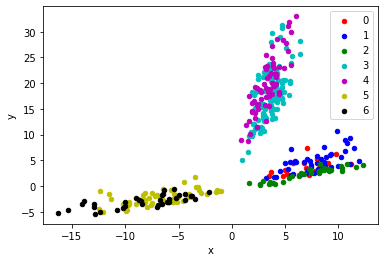

20th learning epochs


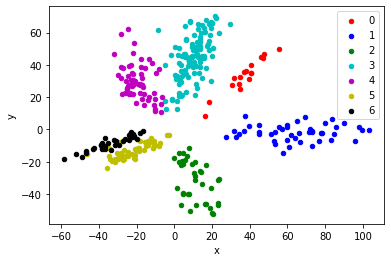

70th learning epochs


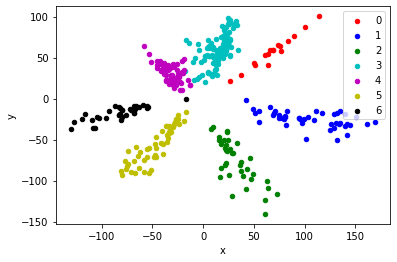

In [21]:
for i in scatter_epoch:
    print('%dth learning epochs'%i[2])
    scatter_plot(i[0], i[1])

### (b) discussions

第一小題的圖片是沒有去背的，而第二小題有去背。
1. learning curve：沒有crop的圖片loss下降的比較慢，且test data的loss會無法下降到太低，相較有crop的圖片，train跟test的loss都可以降得較低，下降的速度也比較快。
2. accuracy：有沒有crop的圖片在train的情況都可以幾乎達到100%，但利用test資料去跑的話，就可以看出還是有crop的圖片預測出的準確度會比較高。
3. latent feature distributions：從5 epoch到70 epoch可以看出同一類別漸漸聚集成同一群，但沒有crop的圖片到了第70個epoch仍然有少數重疊的部分，但有crop的圖片可以明顯看出分群的狀態比較好，重疊的部分也比較少，且群跟群之間也有一些距離。